# CODS example workflow


This juypter notebook is intended to give an introduction to the <b>Combined Degradation and Soiling (CODS)</b> algorithm workflow.

The calculations consist of several steps from the degradation_and_soiling_workflow. This is not meant as an introduction to the RdTools workflow in general, but we show how the CODS algorithm can be used in the context of the general RdTools workflow. The steps involved are:

<ol start="0">
  <li><b>Import and preliminary calculations</b></li>
  <li><b>Normalize</b> data using a performance metric</li>
  <li><b>Filter</b> data that creates bias</li>
  <li><b>Aggregate</b> data</li>
  <li> Run <b>CODS</b> on the aggregated data </li>
  <li> <b>Visualize</b> the results of the CODS algorithm</li>
</ol>

This notebook works with public data from the the Desert Knowledge Australia Solar Centre. Please download the site data from Site 12, and unzip the csv file in the folder:
./rdtools/docs/

Note this example was run with data downloaded on Sept. 8th, 2020. An older version of the data gave different sensor-based results. If you have an older version of the data and are getting different results, please try redownloading the data.

http://dkasolarcentre.com.au/download?location=alice-springs

For more information about CODS, we refer to [1] and [2].

[1]  Skomedal, Å. and Deceglie, M. G. IEEE J. of Photovoltaics, Sept. 2020
[2]  Skomedal, Å., Deceglie, M. G., Haug, H., and Marstein, E. S., Proceedings of the 37th European Photovoltaic Solar Energy Conference and Exhibition, Sept. 2020

In [1]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
import rdtools
from rdtools.soiling import CODSAnalysis
%matplotlib inline

In C:\Users\asmunds\AppData\Local\Continuum\anaconda3\envs\NRELenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\asmunds\AppData\Local\Continuum\anaconda3\envs\NRELenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\asmunds\AppData\Local\Continuum\anaconda3\envs\NRELenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\asmunds\AppData\Local\Continuum\anaconda3\envs\NRELenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated 

In [2]:
#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })
# Register time series plotting in pandas > 1.0
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 0: Import and preliminary calculations

In [3]:
file_name = '84-Site_12-BP-Solar.csv'

df = pd.read_csv(file_name)
try:
    df.columns = [col.decode('utf-8') for col in df.columns]
except AttributeError:
    pass  # Python 3 strings are already unicode literals
df = df.rename(columns = {
    u'12 BP Solar - Active Power (kW)':'power',
    u'12 BP Solar - Wind Speed (m/s)': 'wind_speed',
    u'12 BP Solar - Weather Temperature Celsius (\xb0C)': 'Tamb',
    u'12 BP Solar - Global Horizontal Radiation (W/m\xb2)': 'ghi',
    u'12 BP Solar - Diffuse Horizontal Radiation (W/m\xb2)': 'dhi'
})

# Specify the Metadata
meta = {"latitude": -23.762028,
        "longitude": 133.874886,
        "timezone": 'Australia/North',
        "gamma_pdc": -0.005,
        "azimuth": 0,
        "tilt": 20,
        "power_dc_rated": 5100.0,
        "temp_model_params": pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']}

df.index = pd.to_datetime(df.Timestamp)
# TZ is required for irradiance transposition
df.index = df.index.tz_localize(meta['timezone'], ambiguous = 'infer') 

# Explicitly trim the dates so that runs of this example notebook 
# are comparable when the sourec dataset has been downloaded at different times
df = df['2008-11-11':'2017-05-15']

# Chage power from kilowatts to watts
df['power'] = df.power * 1000.0

# There is some missing data, but we can infer the frequency from the first several data points
freq = pd.infer_freq(df.index[:10])

# Then set the frequency of the dataframe.
# It is reccomended not to up- or downsample at this step
# but rather to use interpolate to regularize the time series
# to it's dominant or underlying frequency. Interpolate is not
# generally recomended for downsampleing in this applicaiton.
df = rdtools.interpolate(df, freq, pd.to_timedelta('15 minutes'))

# Calculate energy yield in Wh
df['energy'] = rdtools.energy_from_power(df.power, max_timedelta=pd.to_timedelta('15 minutes'))

# Calculate POA irradiance from DHI, GHI inputs
loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])
sun = loc.get_solarposition(df.index)

# calculate the POA irradiance
sky = pvlib.irradiance.isotropic(meta['tilt'], df.dhi)
df['dni'] = (df.ghi - df.dhi)/np.cos(np.deg2rad(sun.zenith))
beam = pvlib.irradiance.beam_component(meta['tilt'], meta['azimuth'], sun.zenith, sun.azimuth, df.dni)
df['poa'] = beam + sky

# Calculate cell temperature
df['Tcell'] = pvlib.temperature.sapm_cell(df.poa, df.Tamb, df.wind_speed, **meta['temp_model_params'])

## 1: Normalize

In [4]:
# Specify the keywords for the pvwatts model
pvwatts_kws = {"poa_global" : df.poa,
              "power_dc_rated" : meta['power_dc_rated'],
              "temperature_cell" : df.Tcell,
              "poa_global_ref" : 1000,
              "temperature_cell_ref": 25,
              "gamma_pdc" : meta['gamma_pdc']}

# Calculate the normaliztion, the function also returns the relevant insolation for
# each point in the normalized PV energy timeseries
normalized, insolation = rdtools.normalize_with_pvwatts(df.energy, pvwatts_kws)

df['normalized'] = normalized
df['insolation'] = insolation

## 2: Filter

In [5]:
# Calculate a collection of boolean masks that can be used
# to filter the time series
normalized_mask = rdtools.normalized_filter(df['normalized'])
poa_mask = rdtools.poa_filter(df['poa'])
tcell_mask = rdtools.tcell_filter(df['Tcell'])
clip_mask = rdtools.clip_filter(df['power'])

# filter the time series and keep only the columns needed for the
# remaining steps
filtered = df[normalized_mask & poa_mask & tcell_mask & clip_mask]
filtered = filtered[['insolation', 'normalized']]

## 3: Aggregate

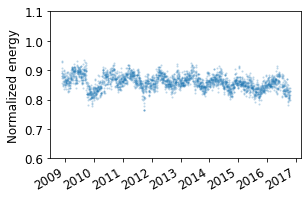

In [6]:
# Calculate the daily normalized energy
daily = rdtools.aggregation_insol(filtered.normalized, filtered.insolation, frequency = 'D')

# The CODS algorithm typically performs better if outliers are removed,
# for instance in this manner
rolling_median = daily.rolling(15, 1, center=True).median()
noise = (daily - rolling_median).abs()
Q3, Q1 = noise.quantile(.75), noise.quantile(.25)
outliers = noise > Q3 + 1.5 * (Q3 - Q1)
daily[outliers] = np.nan

fig, ax = plt.subplots()
ax.plot(daily.index, daily, 'o', alpha = 0.3)
ax.set_ylim(0.6, 1.1)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

## 4: Run CODS

CODS can be run in two ways - either by setting up an instance of `rdtools.soiling.CODSAnalysis` and running the method `run_bootstrap`, or by directly running `rdtools.soiling.soiling_cods`. Here we will show how to do the first option, as this makes more information available, and since the second option is more straightforward. We start by setting up an instance of `rdtools.soiling.CODSAnalysis`:

In [7]:
CODS = CODSAnalysis(daily)

We continue to run `run_bootstrap`. The parameter `reps` decides how many repetitions of the bootstrapping procedure should be performed. `reps` needs to be a multiple of 16, and the minimum is 16. However, to give real confidence intervals, we recommend running it with 512 repetitions. In this case we use 16 to to avoid overly much time use. The parameter `verbose` decides whether to output information about the process during the calculation.

In [8]:
CODS.run_bootstrap(reps=16, verbose=True)
#

Initially fitting 16 models
# 16 | Used: 2.8 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
            order    dt        pt     ff      RMSE     SR==1   weights    sss
0   [SR, SC, Rd]  0.25  0.666667   True  0.014581  0.160745  0.062705  False
1   [SR, SC, Rd]  0.25  0.666667  False  0.014575  0.152121  0.063198  False
2   [SR, SC, Rd]  0.25  1.500000   True  0.014512  0.158675  0.063115  False
3   [SR, SC, Rd]  0.25  1.500000  False  0.014673  0.177303  0.061435  False
4   [SR, SC, Rd]  0.75  0.666667   True  0.014729  0.157641  0.062240  False
5   [SR, SC, Rd]  0.75  0.666667  False  0.014771  0.152811  0.062323  False
6   [SR, SC, Rd]  0.75  1.500000   True  0.014638  0.153846  0.062831  False
7   [SR, SC, Rd]  0.75  1.500000  False  0.014787  0.172128  0.061230  False
8   [SC, SR, Rd]  0.25  0.666667   True  0.014571  0.160400  0.062763  False
9   [SC, SR, Rd]  0.25  0.666667  False  0.014695  0.157296  0.062404  False
10  [SC, SR, Rd]  0.25  1.500000   T

C:\Users\asmunds\AppData\Local\Continuum\anaconda3\envs\NRELenv\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



Bootstrapping for uncertainty analysis (16 realizations):
# 16 | Used: 0.5 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
Final RMSE: 0.01464


(                           soiling_ratio  soiling_rates  cleaning_events  \
 2008-11-14 00:00:00+09:30       1.000000      -0.005111         0.000000   
 2008-11-15 00:00:00+09:30       1.000000       0.000000         0.000000   
 2008-11-16 00:00:00+09:30       1.000000       0.000000         0.056826   
 2008-11-17 00:00:00+09:30       1.000000       0.000000         0.000000   
 2008-11-18 00:00:00+09:30       1.000000       0.000000         0.058202   
 ...                                  ...            ...              ...   
 2016-10-17 00:00:00+09:30       0.963597      -0.001537         0.000000   
 2016-10-18 00:00:00+09:30       0.962062      -0.001533         0.000000   
 2016-10-19 00:00:00+09:30       0.960530      -0.001531         0.000000   
 2016-10-20 00:00:00+09:30       0.958999      -0.001531         0.000000   
 2016-10-21 00:00:00+09:30       0.957468      -0.001531         0.000000   
 
                            seasonal_component  degradation_trend  total_m

## 5: Visualize the results

Avg. Soiling loss 1.888 (1.285, 2.954) (%)
Degradation rate -0.558 (-0.674, -0.440) (%)


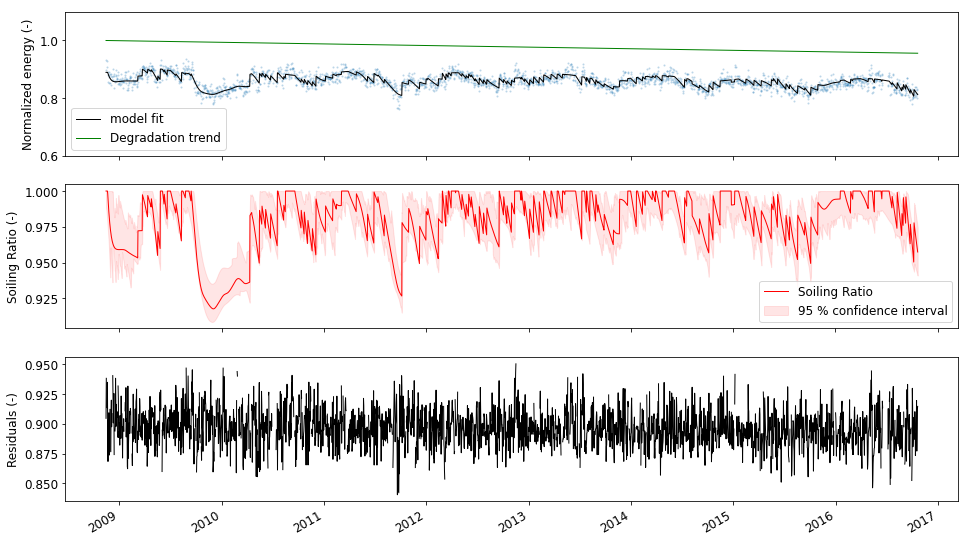

In [9]:
# The average soiling loss over the period with 95 % confidence intervals
# can be accessed through the soiling_loss attribute of CODS
soiling_loss = CODS.soiling_loss
print('Avg. Soiling loss {:.3f} ({:.3f}, {:.3f}) (%)'.format(soiling_loss[0], soiling_loss[1], soiling_loss[2]))

# The estimated degradatio rate over the period with 95 % confidence intervals
# can be accessed through the degradation attribute of CODS
degradation = CODS.degradation
print('Degradation rate {:.3f} ({:.3f}, {:.3f}) (%)'.format(degradation[0], degradation[1], degradation[2]))

# The dataframe containing the time series of the different component fits
# can be accessed through CODS.result_df
result_df = CODS.result_df

# Let us plot the time series of the results
# First: daily normalized energy along with the total model fit and degradation trend
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,10))
ax1.plot(daily.index, daily, 'o', alpha = 0.3)
ax1.plot(result_df.index, result_df.total_model, color='k', linewidth=1,
         label='model fit')
ax1.plot(result_df.index, result_df.degradation_trend, color='g', linewidth=1,
        label='Degradation trend')
ax1.set_ylim(0.6, 1.1)
ax1.set_ylabel('Normalized energy (-)')
ax1.legend()

# Second: soiling ratio with 95 % confidence intervals
ax2.plot(result_df.index, result_df.soiling_ratio, color='r', linewidth=1,
         label='Soiling Ratio')
ax2.fill_between(result_df.index, result_df.SR_low, result_df.SR_high,
                 color='r', alpha=.1, label='95 % confidence interval')
ax2.set_ylabel('Soiling Ratio (-)')
ax2.legend()

# Third: The seasonal component
ax3.plot(result_df.index, result_df.residuals, color='k', linewidth=1)
ax3.set_ylabel('Residuals (-)');

fig.autofmt_xdate()

In [10]:
result_df

,soiling_ratio,soiling_rates,cleaning_events,seasonal_component,degradation_trend,total_model,residuals,SR_low,SR_high,rates_low,rates_high,bt_soiling_ratio,bt_soiling_rates,seasonal_low,seasonal_high,model_low,model_high
2008-11-14 00:00:00+09:30,1.000000,-0.005111,0.000000,0.991929,1.000000,0.889259,0.904690,0.988518,1.000000,-0.007260,0.001200,0.804823,-0.002488,0.986323,0.996559,0.886916,0.904527
2008-11-15 00:00:00+09:30,1.000000,0.000000,0.000000,0.992026,0.999985,0.889333,0.938356,0.987062,1.000000,-0.003257,0.000000,0.925648,-0.000519,0.986414,0.996677,0.886428,0.901829
2008-11-16 00:00:00+09:30,1.000000,0.000000,0.056826,0.992126,0.999969,0.889408,NaN,0.985071,1.000000,-0.002953,0.000000,0.925309,-0.000348,0.986509,0.996794,0.885863,0.899489
2008-11-17 00:00:00+09:30,1.000000,0.000000,0.000000,0.992227,0.999954,0.889486,NaN,0.983046,1.000000,-0.003768,0.000000,0.924827,-0.000733,0.986609,0.996911,0.885269,0.898070
2008-11-18 00:00:00+09:30,1.000000,0.000000,0.058202,0.992330,0.999939,0.889564,0.913713,0.980420,1.000000,-0.003775,0.000000,0.924105,-0.000732,0.986713,0.997028,0.884645,0.896784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-17 00:00:00+09:30,0.963597,-0.001537,0.000000,0.990081,0.955826,0.817510,0.877161,0.943624,0.980099,-0.002137,-0.000260,0.960661,-0.000920,0.985450,0.994261,0.815263,0.831003
2016-10-18 00:00:00+09:30,0.962062,-0.001533,0.000000,0.990112,0.955811,0.816220,0.895910,0.942876,0.978719,-0.002141,-0.000260,0.959743,-0.000920,0.985430,0.994295,0.814266,0.830067
2016-10-19 00:00:00+09:30,0.960530,-0.001531,0.000000,0.990145,0.955796,0.814934,0.912738,0.942127,0.977442,-0.002142,-0.000259,0.958826,-0.000920,0.985413,0.994329,0.813245,0.829134
2016-10-20 00:00:00+09:30,0.958999,-0.001531,0.000000,0.990181,0.955780,0.813652,0.914753,0.941355,0.976166,-0.002142,-0.000259,0.957909,-0.000920,0.985400,0.994365,0.812201,0.828202
